In [1]:
import numpy as np
import matplotlib.pyplot as plt

import cv2
import os
import shutil
import copy

from config_test import Params
from transformers_test import RealNoiseTransformer, FourierTransformer,\
                    FourierNoiseTransformer, InverseFourierTransformer, SaveOnlyArcs
from sklearn.pipeline import Pipeline
from model_creator import create_model


def mas_Gl(ang):
    # ang [mas]
    
    rad = 1e-6*ang/3600/180*np.pi  # radians
    dist = 1/rad/1e+9   # Glambda
    
    return dist

def dict_fields(curr_dict, s=''):
    # response structure
    s += '\t'
    for key in curr_dict.keys():
        if type(curr_dict[key]) is dict:
            print(s + key + ':', type(curr_dict[key]))
            dict_fields(curr_dict[key], s)
            continue
        print(s + key + ':', curr_dict[key])

SMALL_SIZE = 15
MEDIUM_SIZE = 18
BIGGER_SIZE = 21

plt.rcdefaults()

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

%matplotlib inline


2023-11-25 17:44:24.140927: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
SUMMARIES_FOLDER = './summaries/'
if (os.path.exists(SUMMARIES_FOLDER)):
    shutil.rmtree(SUMMARIES_FOLDER)
os.mkdir(SUMMARIES_FOLDER)

for use_phase in [False, True]:
    for use_mask in [False, True]:
        for dropout in Params.DROPOUTS:
            
            part1 = "M$-$"
            if use_mask: part1 = "M$+$"
            if use_phase:
                part1 += "Ph$+$"
            else:
                part1 += "Ph$-$"
            common_title = '[' + part1 + ']'
            
            
            model = create_model(use_mask, use_phase, dropout)
            fname = 'summary_use_mask={}_use_phase={}.txt'.format(str(use_mask), str(use_phase))
            fpath = os.path.join(SUMMARIES_FOLDER, fname)
            with open(fpath, 'w') as f:
                model.summary(line_length=100, print_fn=lambda x: f.write(x + '\n'))

dropout = 0.0


2023-11-25 17:44:25.147778: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-11-25 17:44:25.148506: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-11-25 17:44:26.826491: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-11-25 17:44:26.826526: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: silhouette
2023-11-25 17:44:26.826532: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: silhouette
2023-11-25 17:44:26.826654: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.223.2
2023-11-25 17:44:26.826679: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.223.2
2023-11-25 17:44:26.826684: I tensorflow/stream_executor/cuda/cuda_diagnostics

params 156785
dropout = 0.0
params 156929
dropout = 0.0
params 157073
dropout = 0.0
params 157217


disk_ang=78.00_size=22.50_rot=0.75_val=-1.gz
(128, 128)


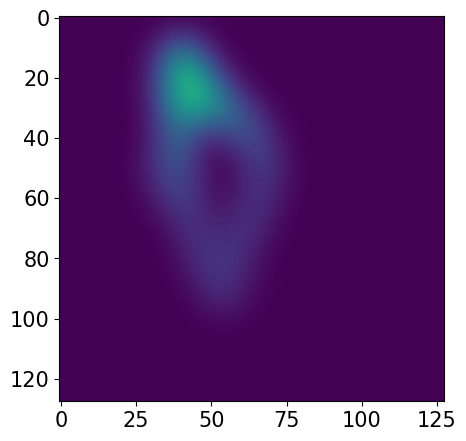

In [3]:
#np.random.seed(234)

path = Params.PIC_FOLDER
pic_path = './figures/'

file = ''

#while not file.endswith('.gz'):
#    file = np.random.choice(os.listdir(path))

file = 'disk_ang=78.00_size=22.50_rot=0.75_val=-1.gz'
#file = 'disk_ang=35.00_size=18.07_rot=0.21_val=+1.gz'
    
print(file)



ext = 'pdf'

pic = np.loadtxt(os.path.join(path,file))
pname = file[:-3] + '.' + ext

print(pic.shape)

real_transformer_kwargs = Params.REAL_TRANSFORMER_KWARGS
fourier_transformer_kwargs = Params.FOURIER_TRANSFORMER_KWARGS

pipe = Pipeline([\
            ('real_noise', RealNoiseTransformer(**real_transformer_kwargs)),\
            ('fourier', FourierTransformer()),\
            ('fourier_noise', FourierNoiseTransformer(**fourier_transformer_kwargs))\
                ])

inverse_transformer = InverseFourierTransformer()

abs_angle_and_mask = (pic.reshape(-1,Params.INITIAL_SIZE,Params.INITIAL_SIZE,1),None,None)
fourier_noise_transformed = pipe.transform(abs_angle_and_mask)
trans_pic,_,_ = inverse_transformer.transform(fourier_noise_transformed)
trans_pic = trans_pic.reshape(Params.INITIAL_SIZE,Params.INITIAL_SIZE)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

ax.imshow(trans_pic, vmin=0.,vmax=1.)

fourier_abs,fourier_angle,mask = fourier_noise_transformed

fourier_angle %= (2*np.pi)
fourier_angle[fourier_angle>np.pi] = fourier_angle[fourier_angle>np.pi] - 2*np.pi

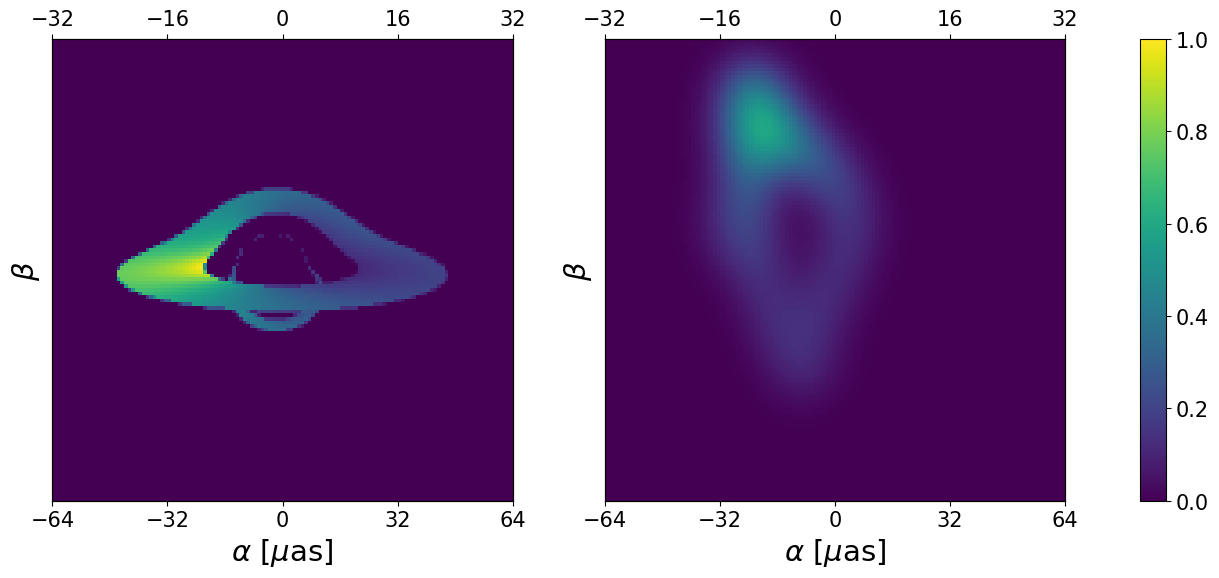

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

plots = [pic, trans_pic]

caxes = []


for ax,to_plot in zip(axes,plots):

    cax = ax.imshow(to_plot, aspect='auto', extent=[-64,64,-64,64], vmin=0., vmax=1.)
    caxes.append(cax)
    #ax.xaxis.set_visible(False)
    #ax.yaxis.set_visible(False)
    #ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    #ax.set_aspect('equal')
    unit_ax = ax.twiny()
    ax.set_xticks(np.linspace(-64,64,5, endpoint=True))
    unit_ax.set_xticks(np.linspace(-32,32,5, endpoint=True))
    #unit_ax.set_aspect('equal')
    
    ax.set_xlabel('$\\alpha$ [$\mu$as]')
    ax.set_ylabel('$\\beta$')


pos = ax.get_position()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, pos.y0, 0.05*pos.width, pos.height])
fig.colorbar(cax, cax=cbar_ax)


#fig.savefig(os.path.join(pic_path,pname[:-(len(ext)+1)] + '_aug.' + ext), bbox_inches='tight')


In [5]:
N = Params.INITIAL_SIZE
k_pad = Params.FFT_S
L = 1

M = k_pad*N

dl = L/(N-1)
nuNyqst = 1/2/dl
dnu = (N-1)/M/L

print('k_max = ', 2*np.pi*nuNyqst)
print('nu per pixel = ', dnu*36*18/np.pi/N/0.5)

u = -nuNyqst + dnu*np.arange(M)
v = -nuNyqst + dnu*np.arange(M)

u,v = np.meshgrid(u,v)

mas = 128
scale = mas_Gl(mas)
scale1 = mas_Gl(mas/2)
u_scaled = scale*u
v_scaled = scale*v
u_scaled1 = scale1*u
v_scaled1 = scale1*v

Fs = np.fft.fftshift(np.fft.fftn(trans_pic, axes=(0,1), s=(M,M))*dl**2, axes=(0,1))
Fs_corr = np.exp(1j*np.pi*(u+v)*L)*Fs
#Fs_corr = np.fft.fftshift(Fs, axes=(0,1))
#F_theor = F_bess(2*np.pi*u,2*np.pi*v,R)
#F_corr = np.fft.fftshift(F)



k_max =  398.98226700590374
nu per pixel =  1.5988543941272728


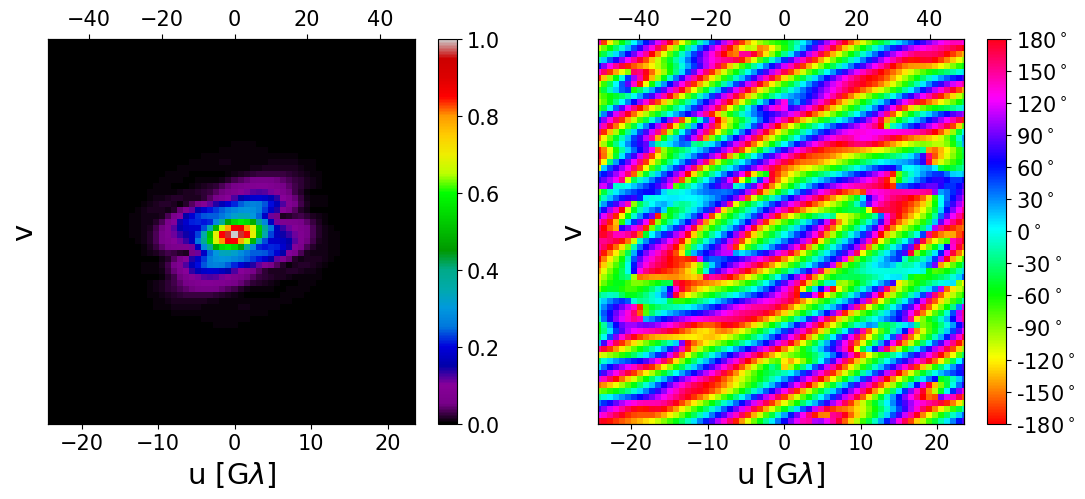

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(13,5))

a = int(M/2 - Params.FINAL_SIZE/2)
extent = [u_scaled[a:-a,a:-a].min(),u_scaled[a:-a,a:-a].max(),\
                                                     v_scaled[a:-a,a:-a].min(),v_scaled[a:-a,a:-a].max()]
colors = ['nipy_spectral', 'hsv']

func = np.absolute(Fs_corr)[a:-a,a:-a]

fourier_abs = fourier_abs.reshape(M,M)
fourier_angle = fourier_angle.reshape(M,M)
plots = [fourier_abs[a:-a,a:-a]/fourier_abs[a:-a,a:-a].max(), (180/np.pi)*fourier_angle[a:-a,a:-a]]

for ax,color,to_plot in zip(axes,colors,plots):

    cax = ax.imshow(to_plot, cmap=color,\
                    interpolation='none', extent=extent)
    #ax.xaxis.set_visible(False)
    #ax.yaxis.set_visible(False)
    #ax.xaxis.set_major_locator(plt.NullLocator())
    unit_ax = ax.twiny()
    u_min = u_scaled1[a:-a,a:-a].min()
    u_max = u_scaled1[a:-a,a:-a].max()
    aux = np.arange(0,u_max,20)
    u_ticks = sorted(np.concatenate([[-t for t in aux[1:]],aux]))
    unit_ax.set_xlim(u_min,u_max)
    unit_ax.set_xticks(u_ticks)
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.set_xlabel('u [G$\lambda$]')
    ax.set_ylabel('v')
    cbar = fig.colorbar(cax, orientation="vertical", pad=0.05, ax=ax)

    

cticks = np.linspace(-180,180,13, endpoint=True)
clabels = [str(int(tick))+'$^\circ$' for tick in cticks]
cax.set_clim(cticks.min(),cticks.max())
cbar.set_ticks(cticks) 
cbar.set_ticklabels(clabels)


for ax in axes:
    ax.set_aspect('equal')
# fig.savefig(os.path.join(pic_path,pname[:-(len(ext)+1)] + '_fourier.' + ext), bbox_inches='tight')

In [7]:

save_only_arcs_transformer_kwargs = Params.SAVE_ONLY_ARCS_TRANSFORMER_KWARGS

save_only_arcs_transformer_kwargs['radius_params']['radius_delta'] = 1
save_only_arcs_transformer_kwargs['radius_params']['is_radius_uniform'] = True
save_only_arcs_transformer_kwargs['epoch'] = 100
save_only_arcs_transformer_kwargs['writable'] = False

#dict_fields(save_only_arcs_transformer_kwargs)


Average filled_part:  0.016845703125
0.016845703125
Average filled_part:  0.01708984375
0.140869140625
Average filled_part:  0.600341796875
0.600341796875


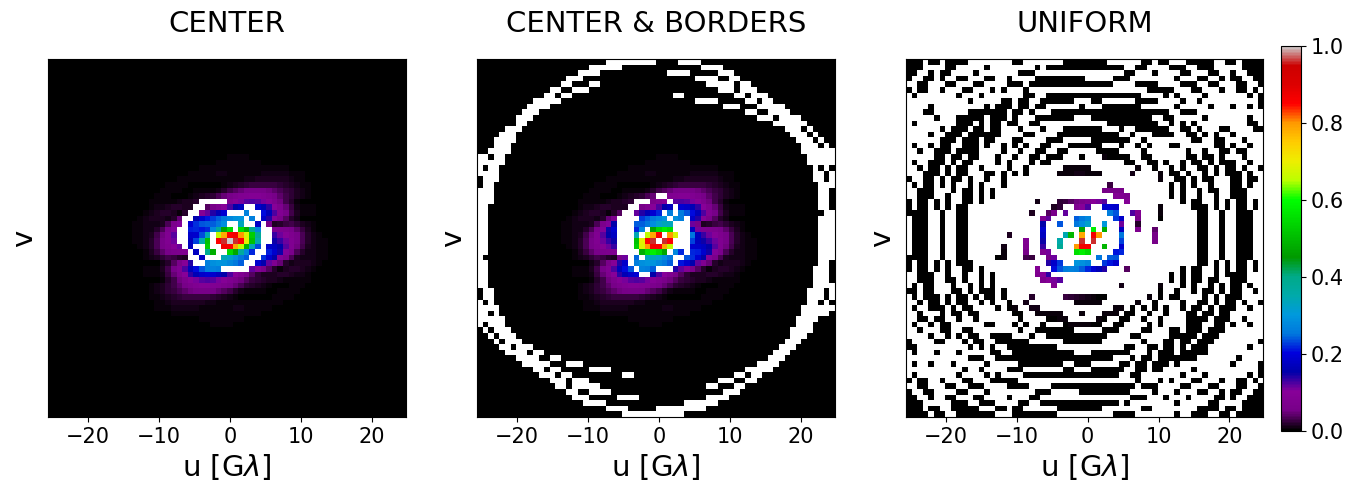

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(18,5))

a = int(M/2 - Params.FINAL_SIZE/2)
extent = [u_scaled[a:-a,a:-a].min(),u_scaled[a:-a,a:-a].max(),\
                                                     v_scaled[a:-a,a:-a].min(),v_scaled[a:-a,a:-a].max()]
color = 'nipy_spectral'
to_plot = fourier_abs[a:-a,a:-a]/fourier_abs[a:-a,a:-a].max()


modes = [True,True,False]
borders = [False,True,False] 
titles = ["CENTER", "CENTER & BORDERS", "UNIFORM"]


fills = [0.60]*3




for ax,mode,border,fill,title in zip(axes,modes,borders,fills,titles):

    label = 'mode=' + str(mode) + ', border=' + str(border)
    cax = ax.imshow(to_plot, cmap=color,\
                    interpolation='none', extent=extent, aspect='equal')
    #ax.xaxis.set_visible(False)
    #ax.yaxis.set_visible(False)
    #ax.xaxis.set_major_locator(plt.NullLocator())
    #unit_ax = ax.twiny()
    #u_min = u_scaled1[a:-a,a:-a].min()
    #u_max = u_scaled1[a:-a,a:-a].max()
    #aux = np.arange(0,u_max,20)
    #u_ticks = sorted(np.concatenate([[-t for t in aux[1:]],aux]))
    #unit_ax.set_xlim(u_min,u_max)
    #unit_ax.set_xticks(u_ticks)
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.set_xlabel('u [G$\lambda$]')
    ax.set_ylabel('v')
    #cbar = fig.colorbar(cax, orientation="vertical", pad=0.05, ax=ax)
    
    save_only_arcs_transformer_kwargs['min_filled_part'] = fill
    save_only_arcs_transformer_kwargs['special_mode'] = mode
    save_only_arcs_transformer_kwargs['add_borders'] = border
    
    trans_arcs = SaveOnlyArcs(**save_only_arcs_transformer_kwargs)
    mask = trans_arcs.create_mask(64,1,False)[0]
    #print(trans_arcs.create_mask(64,10).shape)
    
    '''
    size = int(64*Params.CENTER_RADIUS_PART) + 2
    frame = np.zeros((size,size))
    frame[0,:] += 1
    frame[:,0] += 1
    frame[-1,:] += 1
    frame[:,-1] += 1
    a = int(32 - size/2)
    mask[a:-a,a:-a] += frame
    mask = np.minimum(1, mask)
    '''
    
    if mode:
        #print(np.sum(mask)/mask.shape[0]/mask.shape[1]/Params.CENTER_RADIUS_PART**2)
        print(np.sum(mask)/mask.shape[0]/mask.shape[1])
        #print(np.sum(mask))
    else:
        print(np.sum(mask)/mask.shape[0]/mask.shape[1])
        #print(np.sum(mask))
    my_cmap = copy.copy(plt.cm.get_cmap('binary')) # get a copy of the gray color map
    my_cmap.set_bad(alpha=0)
    mask[mask == 0.] = np.nan
    
    ax.imshow(mask, cmap=my_cmap, extent=extent)
    ax.set_title(title, pad=20)
    ax.locator_params(axis='x', nbins=6)
    

pos = ax.get_position()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, pos.y0, 0.05*pos.width, pos.height])
fig.colorbar(cax, cax=cbar_ax)

for ax in axes:
    ax.set_aspect('equal')
#fig.savefig(os.path.join(pic_path,pname[:-(len(ext)+1)] + '_mask_060.' + ext), bbox_inches='tight')

## ML models

In [9]:
import pandas as pd
import json

from glob import iglob
import re

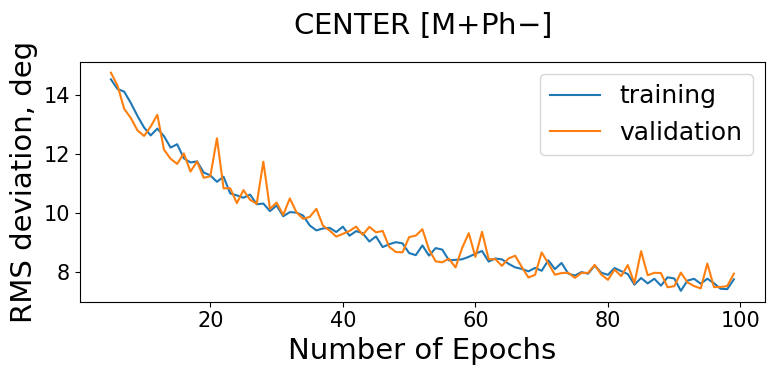

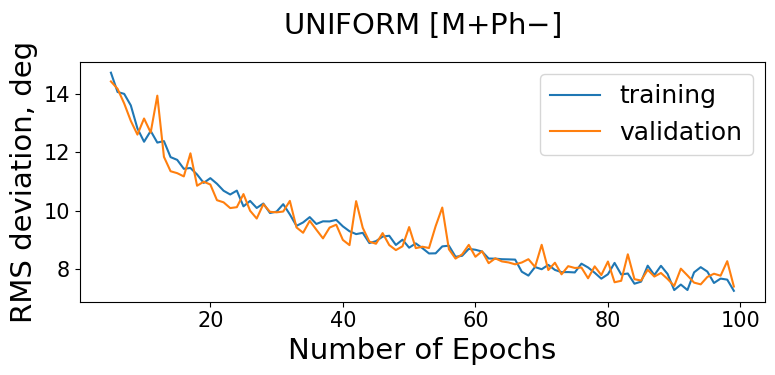

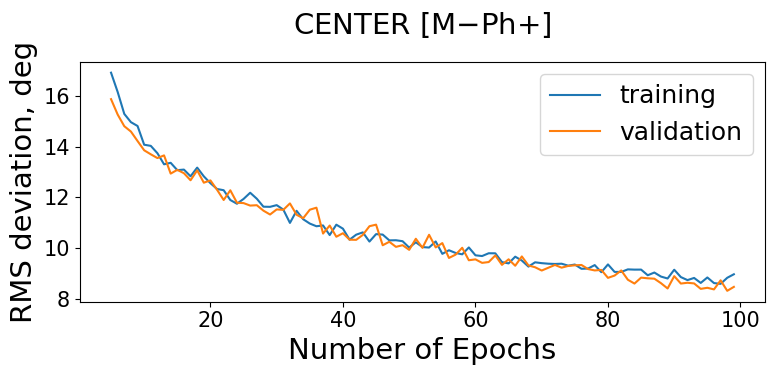

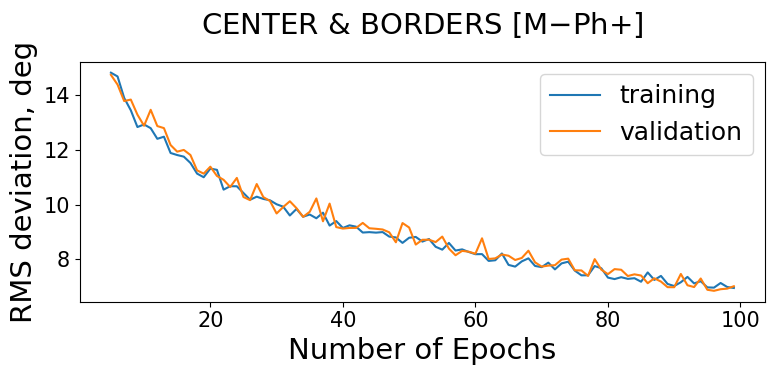

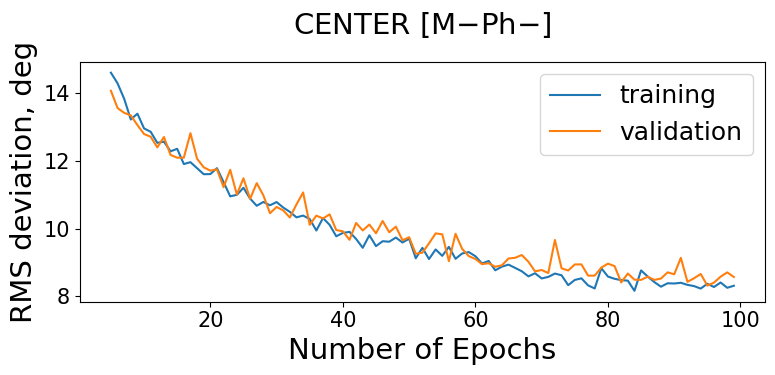

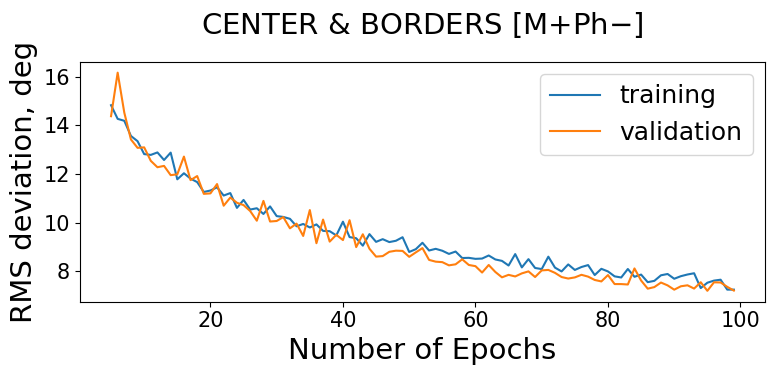

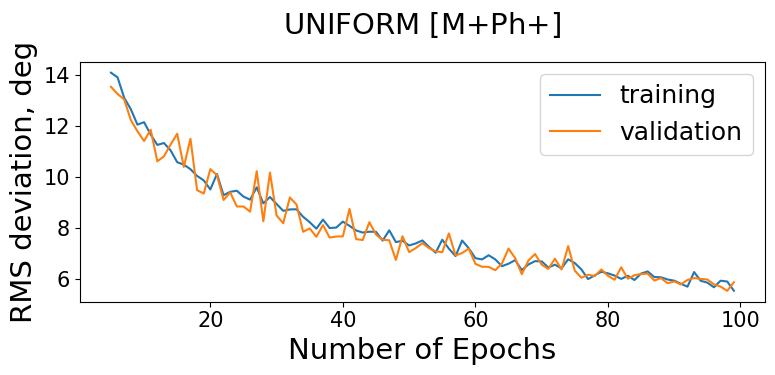

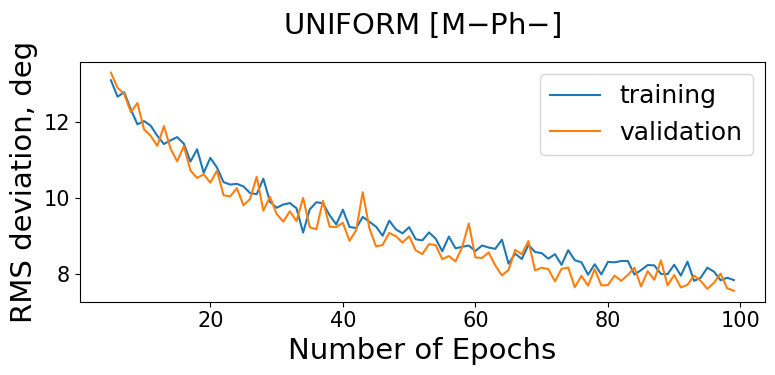

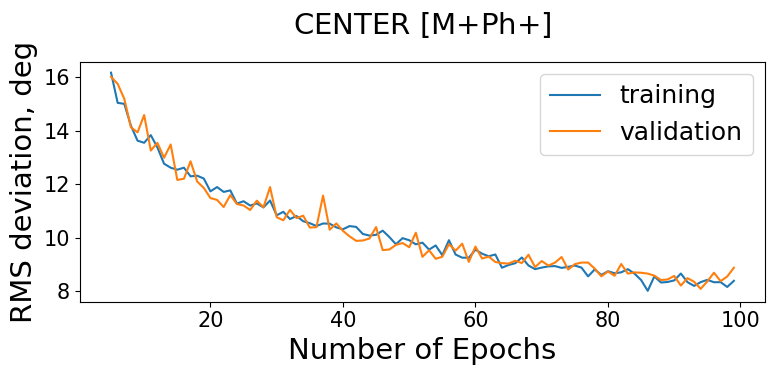

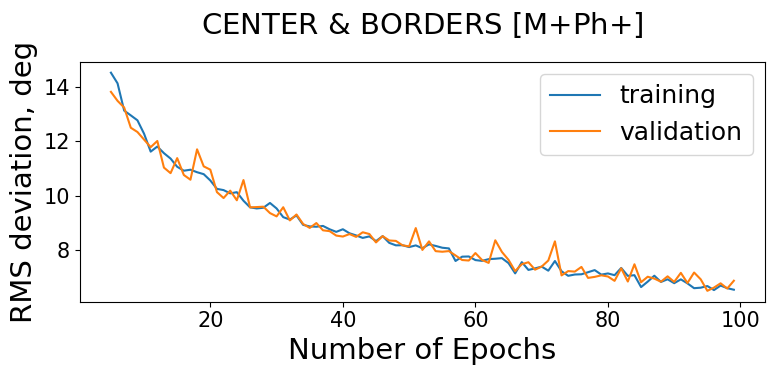

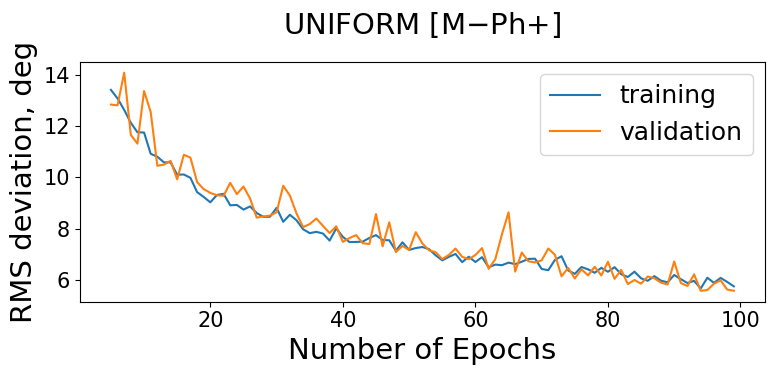

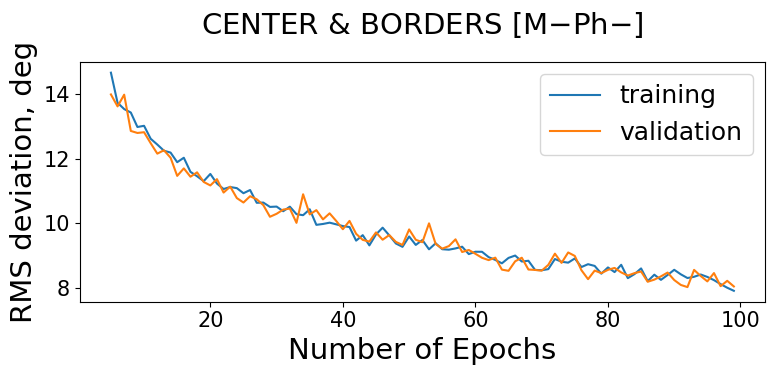

In [10]:
def conv_bool(bool_str):
    valid = {'True','False'}
    if bool_str not in valid:
        raise ValueError("results: status must be one of %r." % valid)
    return bool_str == 'True'

history_folder = '../histories/'
expr = r'history mask=(.+) phase=(.+) dropout=.+ special_mode=(.+) add_borders=(.+).txt'


file_pars = [(f,re.findall(expr, f)[0])\
               for f in iglob(os.path.join(history_folder,'*')) if re.findall(expr, f)]
#fpars_sorted = sorted(file_pars, key=lambda x: float(x[1][0]))

#fig,ax = plt.subplots(ncols=1, nrows=1, figsize=(10,5))

a = 5

'''
for fname,pars in file_pars:
    with open(fname, 'r') as history_file:
        data = json.load(history_file)

    df = pd.DataFrame(data)
    b = len(df)

    ax.plot(df.mean_squared_error[a:b], c='white', label='_')
    ax.plot(df.val_mean_squared_error[a:b], c='white', label='_')

ylim = ax.get_ylim()
'''

for fname,pars in file_pars[::-1]:
    fig,ax1 = plt.subplots(ncols=1, nrows=1, figsize=(8,4))
    with open(fname, 'r') as history_file:
        data = json.load(history_file)

    df = pd.DataFrame(data)
    b = len(df)
    label_train = 'training' 
    label_val = 'validation'

    ax1.plot(90*np.sqrt(df.mean_squared_error[a:b]), label=label_train)
    ax1.plot(90*np.sqrt(df.val_mean_squared_error[a:b]), label=label_val)
    ax1.set_xlabel('Number of Epochs')
    #ax1.set_ylim(ylim)
    
    part1 = "M$-$"
    if conv_bool(pars[0]): part1 = "M$+$"
    if conv_bool(pars[1]):
        part1 += "Ph$+$"
    else:
        part1 += "Ph$-$"
    
    part2 = "UNIFORM"
    if conv_bool(pars[2]):
        if conv_bool(pars[3]): 
            part2 = "CENTER & BORDERS"
        else:
            part2 = "CENTER"
    
    ax1.set_title(part2 + ' [' + part1 + ']', pad=20)
    ax1.set_ylabel('RMS deviation, deg')
    ax1.legend(loc='upper right')
    fig.tight_layout()
    pic_name = 'pic_history_mask={}_phase={}_sp={}_border={}.pdf'.format(pars[0],pars[1],pars[2],pars[3])
    #fig.savefig(os.path.join(pic_path,pic_name))
    



## Errors

In [11]:
from pic_generator_test import PicGeneratorArcs
from model_creator import create_model
from tqdm import tqdm
from tensorflow.keras.models import load_model

def create_pic_generator_arc(batch_size, blur_sigma, min_filled_part, special_mode, add_borders,\
                            use_mask, use_phase, epoch):  
    return PicGeneratorArcs().batch_generator(batch_size, blur_sigma, min_filled_part,\
                                              use_mask, use_phase, special_mode, add_borders, epoch, writable=False)





In [17]:
blur_sigma = Params.BLUR_SIGMA_VALUES[0]
dropouts = Params.DROPOUTS

use_mask = False
use_phase = True
epoch = 100
size = Params.BATCH_SIZE

models = "../models_{}/"
results = "./test_results_{}/"

addendum = ''
if use_mask:
    addendum += 'mask'
if use_phase:
    addendum += 'phase'
if len(addendum) == 0:
    addendum += 'nothing'

MOD = seed_models.format(addendum)
RESULTS_FOLDER = seed_results.format(addendum)

folder_path

'./test_results_mask/'

### Error vs. Coverage

In [13]:
import numpy.polynomial.polynomial as poly
from scipy.optimize import curve_fit
#import seaborn as sns
from scipy import stats
import matplotlib.cm as cm

def plot_data(data_files_fparts,cutoffs,axes,color_scheme, use_mask, use_phase, start=0.5, end=1., order=True):

    part1 = "M$-$"
    if use_mask: part1 = "M$+$"
    if use_phase:
        part1 += "Ph$+$"
    else:
        part1 += "Ph$-$"

    common_title = '[' + part1 + ']'
    
    scale = 90.
    errs = []
    fparts = []
    #fig_err, axes = plt.subplots(ncols=2, nrows=1, figsize=(10,5))
    ax1,ax2 = axes
    
    #print(((len(data_files_fparts) - shift - 1)  // each) + 1)
    for k,fname in enumerate(data_files_fparts):
        with open(fname[0], 'r') as f:
            data = json.load(f)
            fpart = fname[1]
            err = scale*np.sqrt(data['l2_loss'])
            #err2 = err**2
            #prediction = scale*np.array(data['prediction'])
            #y = scale*np.array(data['real_angles'])
            #dy =  prediction - y

            errs.append(err)
            fparts.append(fpart)
            
    errs = np.array(errs)
    fparts = np.array(fparts)

    first,last,nums = cutoffs
    bins = np.linspace(first,last,nums)
    digs = np.digitize(fparts, bins=bins)
    ids = np.where(~np.logical_or(digs == 0,digs == len(bins)))[0]

    hist_files = [data_files_fparts[i] for i in ids[::len(ids)-1]]
    hist_bins = bins[::len(bins)-1]

    num = 0
    
    colors = color_scheme(np.linspace(start,end, len(hist_files)))
    if not order:
        colors = colors[::-1]
    
    for fname,hbin in zip(hist_files,hist_bins):
        with open(fname[0], 'r') as f:
            data = json.load(f)
            fpart = hbin
            if abs(fpart-fname[1]) > 0.1:
                fpart = fname[1] 
            err = scale*np.sqrt(data['l2_loss'])
            err2 = err**2
            prediction = scale*np.array(data['prediction'])
            y = scale*np.array(data['real_angles'])
            dy =  prediction - y

        num += 1

        color=colors[num-1]

        ax1.scatter(y,prediction, s=5, color=color)
        xs = np.linspace(0.,scale, 100)
        ax1.plot(xs,xs, c='green', lw=2.5)
        ax1.set_ylim(ax1.get_xlim())
        ax1.set_xticks([0,30,60,90])
        ax1.set_yticks([0,30,60,90])
        ax1.set_aspect('equal')
        
        plusminus = np.percentile(dy, [16, 50, 84])
        q = np.diff(plusminus)
        q_gauss = np.sqrt(np.sum(dy**2)/len(dy))
        label = "{:.0f}%, $[-{:.0f}\degree, +{:.0f}\degree]$".format(100*fpart,q[0],q[1])

#         ax2.hist(dy, bins=30, density=True, color=color, alpha=0.6,\
#                  label='{:.0f}%, $\pm${:.0f}$\degree$'.format(100*fpart,err))
        ax2.hist(dy, bins=30, density=True, color=color, alpha=0.6,\
                  label=label)
        #ax2 = sns.distplot(dy, color=colors[num-1], kde=False, fit=stats.norminvgauss)
        ax2.set_xlim(-60,60)
        ax2.set_xticks([-60,-30,0,30,60])
        ax1.annotate(common_title, xy=(0.1,0.9), xycoords='axes fraction', fontsize=plt.rcParams['legend.fontsize'])


        xmin,xmax = ax2.get_xlim()
        #print(xmin,xmax)
        ts = np.linspace(xmin,xmax,100)
        ax2.plot(ts, np.exp(-(ts - np.average(dy))**2/2/err2)/np.sqrt(2*np.pi*err2), lw=2.5,\
                 color=color)
        ax2.yaxis.tick_right()
        ax2.yaxis.set_label_position('right')
        #ax2.set_adjustable('box')
        #ax2.set_yticks([0.,0.05,0.1])
        #ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        ax2.legend(loc='upper left')


    print('Total hists: ', num)    
    return fparts,errs,common_title

# def rational(x, p, q):
#     """
#     The general rational function description.
#     p is a list with the polynomial coefficients in the numerator
#     q is a list with the polynomial coefficients (except the first one)
#     in the denominator
#     The zeroth order coefficient of the denominator polynomial is fixed at 1.
#     Numpy stores coefficients in [x**2 + x + 1] order, so the fixed
#     zeroth order denominator coefficent must comes last. (Edited.)
#     """
#     return poly.Polynomial(p)(x) / poly.Polynomial(q)(x)


# def rational3_3(x, p0, p1, p2, q1, q2, q3):
#     return rational(x, [p0, p1,p2], [q1,q2,q3])

# class Pade:
#     def __init__(self, *coefs):
#         self.coefs = coefs
        
#     def __call__(self,x):
#         return rational3_3(x, *self.coefs)

def poly_curvefit(x, *coefs):
    return poly.Polynomial(coefs)(x)

(2,)
Total hists:  2
err =  0.495510693205685
Total hists:  2
err =  0.4908874377893336
Total hists:  2
err =  0.5593602529681856


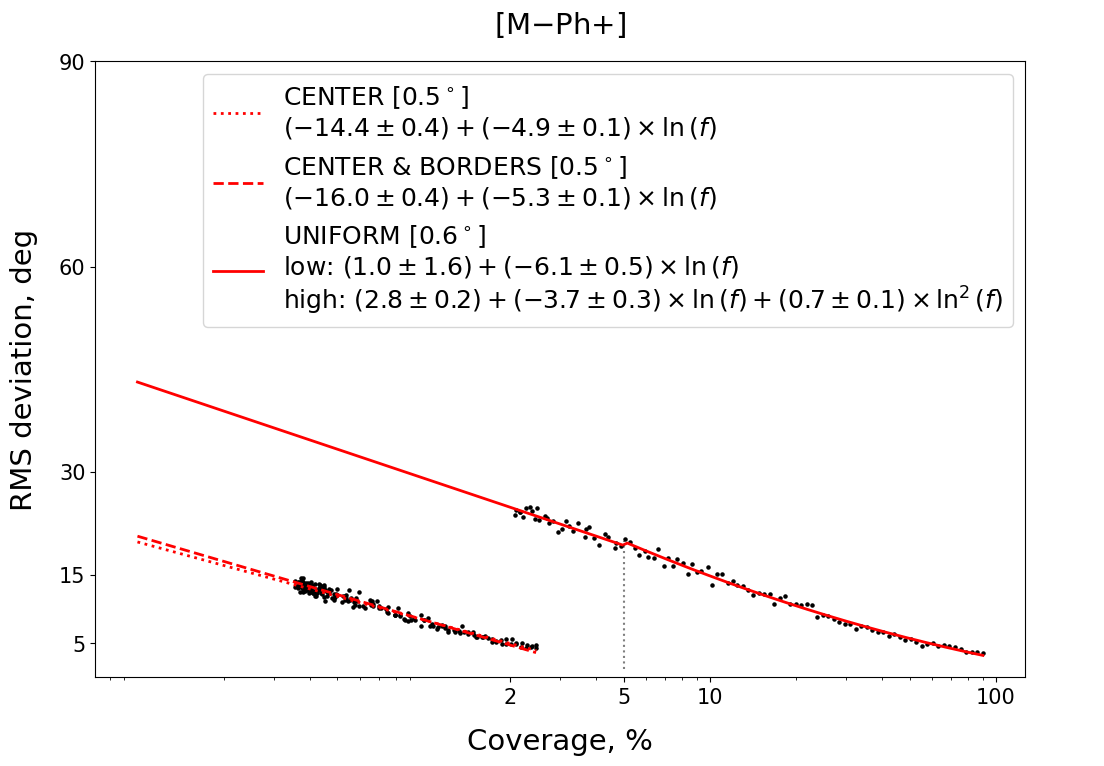

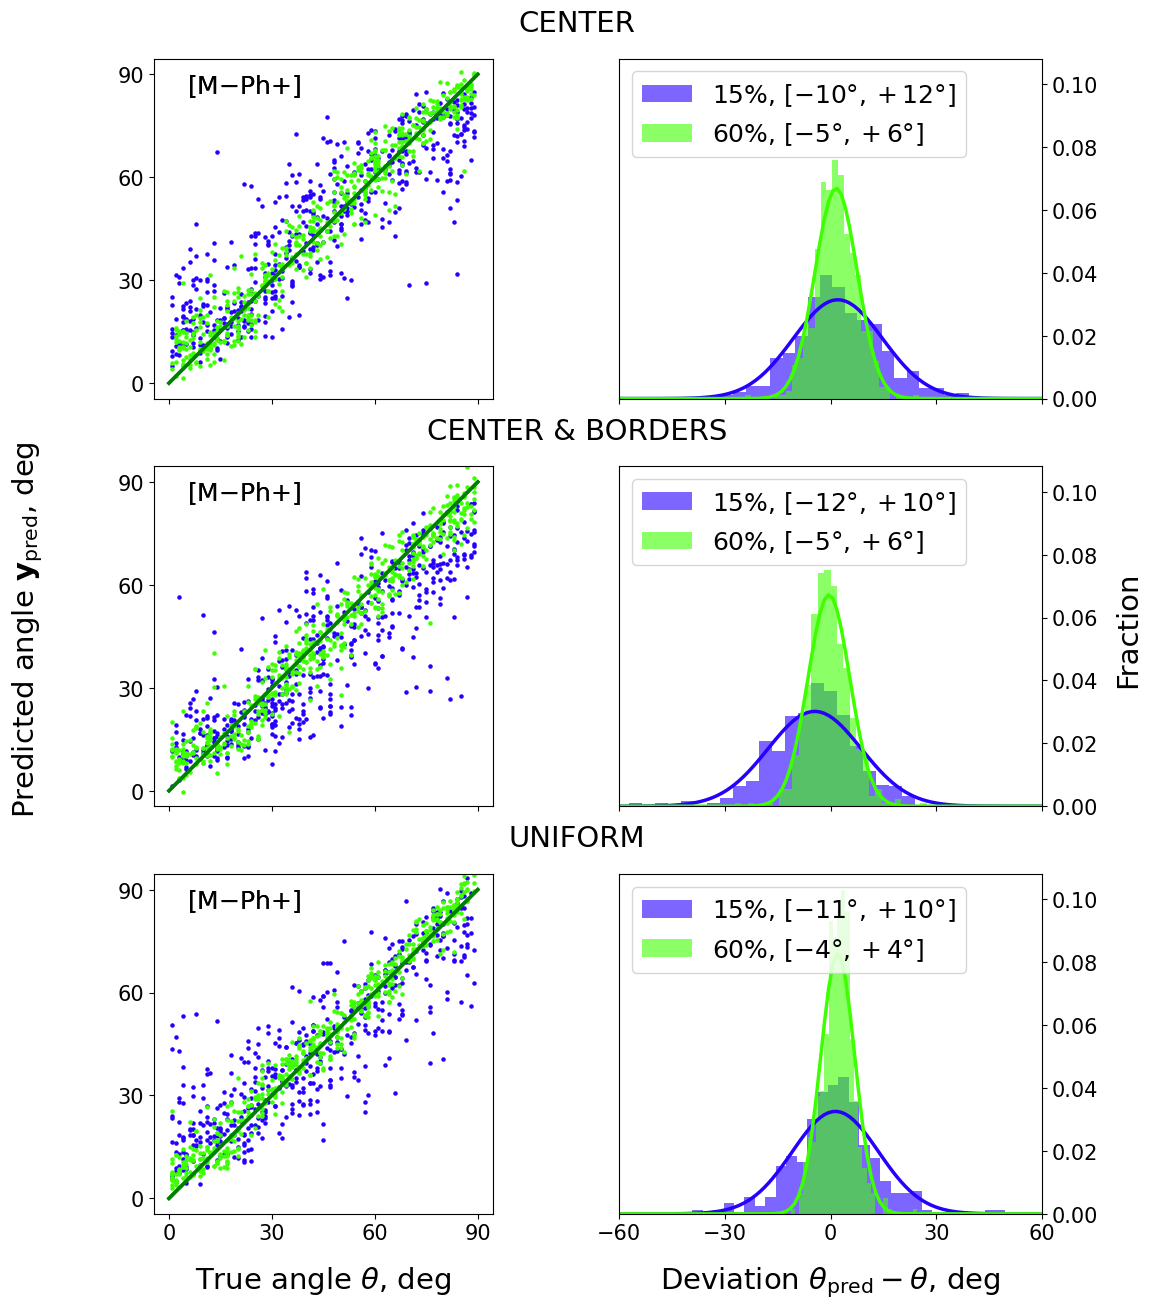

In [16]:
from matplotlib import ticker
from matplotlib.lines import Line2D

modes = [True,True,False]
borders = [False,True,False] 
titles = ["CENTER", "CENTER & BORDERS", "UNIFORM"]
styles = ['solid', 'dashed', 'dotted']
#markers = ['o', '^', 's']
markers = ['o', 'o', 'o']



fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12,8))
fig_err, axes = plt.subplots(ncols=2, nrows=3, figsize=(12,15),\
                             sharex='col', sharey='col')
#fig_err.subplots_adjust(hspace=1.5, wspace=0.5)

fig_err.text(0.04, 0.5, 'Predicted angle $\mathbf{y}_{\mathrm{pred}}$, deg',\
             va='center', rotation='vertical', size=plt.rcParams['axes.labelsize'])

fig_err.text(0.96, 0.5, 'Fraction',\
             va='center', rotation='vertical', size=plt.rcParams['axes.labelsize'])


axinv1 = fig_err.add_subplot(121, frameon=False)
axinv2 = fig_err.add_subplot(122, frameon=False)
axinv1.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
axinv2.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
axinv1.set_ylabel('Predicted angle $\mathbf{y}_{\mathrm{pred}}$, deg', color='none')
axinv2.set_ylabel('Fraction', labelpad=30, color='none')
axinv2.yaxis.set_label_position('right')

ax_right = fig.add_subplot(111, frameon=False)
ax_right.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
ax_right.set_ylabel('Fraction', labelpad=30, color='none')
ax_right.yaxis.set_label_position('right')




axt1 = fig_err.add_subplot(311, frameon=False)
axt2 = fig_err.add_subplot(312, frameon=False)
axt3 = fig_err.add_subplot(313, frameon=False)
axest = (axt1,axt2,axt3)

for axt in axest:
    axt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)


legend_elements = []

print(axes[0,:].shape)

for mode,border,ax1,ax2,axt,title,style,marker in\
 zip(modes,borders,axes[:,0],axes[:,1],axest,titles,styles[::-1],markers):
    
    axes_pair = (ax1,ax2)

    reg = r'blur_.+_dropout_.+_filled_part_(.+)_epoch_' + str(epoch) + '_sp_' + str(mode) +\
            '_borders_' + str(border) + '.json'

    reg_txt = r'filled_parts_epoch_' + str(epoch) + '_sp_' + str(mode) + '_borders_' + str(border) + '.txt'

    json_files = [f for f in os.listdir(folder_path) if f.endswith(".json")]
    txt_files = [f for f in os.listdir(folder_path) if f.endswith(".txt")]

    data_files = sorted([(os.path.join(folder_path,f), int(float(re.findall(reg,f)[0]))-1)\
                         for f in json_files if re.findall(reg,f)], key=lambda x: x[1])
    cov_files = [os.path.join(folder_path,f) for f in txt_files if re.findall(reg_txt,f)]

    assert len(cov_files) == 1 , 'More than one file with filled_parts!!!'

    df = pd.read_table(cov_files[0], header=None, names=['average_fpart'])
    
    data_files_fparts = sorted([(fname[0], df.average_fpart[fname[1]]) for fname in data_files],\
                              key=lambda x: x[1])
    

    fparts, errs, common_title = plot_data(data_files_fparts, (0.15,0.6,10), axes_pair, cm.hsv, use_mask, use_phase, .7, 0.3)
    axt.set_title(title, pad=20)
    
    order = 3
    if mode:
        fparts *= Params.CENTER_RADIUS_PART**2
        order = 2
    
    xfit = np.log(fparts)
    yfit = errs
    
    p0 = tuple([1]*order)

    coefs,cov_mat = curve_fit(poly_curvefit, xfit, yfit, p0=p0)
    coefs_err = np.sqrt(cov_mat.diagonal())
    approx_func = poly.Polynomial(coefs)
    if not mode and use_phase:
        x0 = 5
        cond = 100*np.exp(xfit) < x0
        x_low = xfit[cond]
        y_low = yfit[cond]
        x_high = xfit[~cond]
        y_high = yfit[~cond]

        coefs_low,cov_low = curve_fit(poly_curvefit,x_low,y_low, p0=(1,1))
        coefs_high,cov_high = curve_fit(poly_curvefit,x_high,y_high, p0=(1,1,1))
        err_low = np.sqrt(cov_low.diagonal())
        err_high = np.sqrt(cov_high.diagonal())
        approx_func = np.vectorize(lambda x: poly_curvefit(x,*coefs_low)\
                                   if x<np.log(x0/100) else poly_curvefit(x,*coefs_high))

    scatter_err = np.sqrt(np.sum((errs - approx_func(np.log(fparts)))**2)/len(errs))
    print('err = ', scatter_err)
    
#     coefs,cov_mat = curve_fit(poly_curvefit, xfit, yfit, p0=p0, sigma=scatter_err/fparts)
#     coefs_err = np.sqrt(cov_mat.diagonal())
#     approx_func = poly.Polynomial(coefs)
#     scatter_err = np.sqrt(np.sum((errs - np.exp(approx_func(fparts)))**2)/len(errs))
#     print('err = ', scatter_err)

    cond = fparts > -0.1
    #x = np.log(np.linspace(min(0.15,fparts.min()),fparts.max(),500))
    x = np.log(np.linspace(0.1/100,fparts.max(),500))
    #y_err = np.sum((np.vander(x, N=order, increasing=True)*coefs_err)**2,axis=1)
#     y_err = []
#     for val in x:
#         mat = np.vander([val], N=order, increasing=True)
#         y_err.append(mat @ cov_mat @ mat.T)
#     y_err = np.sqrt(np.array(y_err).reshape(len(x),))
    
        
    
    if mode:
        label = title + ' [${:.1f}^\circ$]'.format(scatter_err)\
                        + '\n$({0:.1f}\pm{2:.1f}) + ({1:.1f}\pm{3:.1f})\\times\ln{{(f)}}$'.\
                                format(*coefs,*coefs_err)
    else:
        label = title + ' [${:.1f}^\circ$]'.format(scatter_err)\
                        + '\n$({0:.1f}\pm{3:.1f}) + ({1:.1f}\pm{4:.1f})\\times\ln{{(f)}} + \
                                ({2:.1f}\pm{5:.1f})\\times\ln^{{2}}{{(f)}}$'.\
                                format(*coefs,*coefs_err, scatter_err)
        if use_phase:
            label = title + ' [${:.1f}^\circ$]'.format(scatter_err) +\
                            '\n' + 'low: $({0:.1f}\pm{2:.1f}) + ({1:.1f}\pm{3:.1f})\\times\ln{{(f)}}$'.\
                                format(*coefs_low,*err_low) +\
                            '\n' + 'high: $({0:.1f}\pm{3:.1f}) + ({1:.1f}\pm{4:.1f})\\times\ln{{(f)}} + \
                                ({2:.1f}\pm{5:.1f})\\times\ln^{{2}}{{(f)}}$'.\
                                format(*coefs_high,*err_high)
    #ax.loglog(100*np.exp(x),np.exp(polyfunc(x)), label=marker + label, linestyle=style, color='red', lw=2)
    ax.semilogx(100*np.exp(x),approx_func(x), label=marker + label, linestyle=style, color='red', lw=2)
    #ax.fill_between(100*np.exp(x),approx_func(x)-y_err,approx_func(x)+y_err,alpha=0.2)
    ax.scatter(100*np.exp(xfit)[cond],yfit[cond], s=5, color='black', marker=marker)
    legend_elements.append(Line2D([0],[0], label=label, color='red', linestyle=style, lw=2))
    ax.set_title(common_title, pad=20)
    #ax.set_xlim(0.15,0.25)
    
ax1.set_xlabel('True angle $\\theta$, deg', labelpad=15)
ax2.set_xlabel('Deviation $\\theta_{\mathrm{pred}}-\\theta$, deg', labelpad=15)

if use_phase:
    ax.set_xticks([2, x0, 10, 100])
else:
    ax.set_xticks([2, 10, 100])
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax.set_yticks([5,15,30,60,90])
ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())
ax.set_xlabel('Coverage, %', labelpad=15)
ax.set_ylabel('RMS deviation, deg', labelpad=15)
ax.legend(handles=legend_elements)

if not mode and use_phase:
    ymin,_ = ax.get_ylim()
    yv = np.linspace(ymin,approx_func(np.log(x0/100)),100)
    xv = np.full(yv.shape, x0)
    ax.plot(xv,yv,linestyle='dotted',color='black',alpha=0.5)
    ax.set_ylim(0,90)



h_name = ('histograms_' + 'mask={}_' + 'phase={}').format(use_mask, use_phase)
c_name = ('coverage_' + 'mask={}_' + 'phase={}').format(use_mask, use_phase)


# fig_err.tight_layout()
# fig_err.savefig(os.path.join(pic_path,h_name + '.png'))
# fig_err.savefig(os.path.join(pic_path,h_name + '.pdf'))

# fig.tight_layout()
# fig.savefig(os.path.join(pic_path,c_name + '.png'))
# fig.savefig(os.path.join(pic_path,c_name + '.pdf'))